In [2]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from tqdm import tqdm
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat
from lib.datasets.mnist_fid import evaluate_fid_score
def categorical_log_likelihood(x, logits):
    """Log likelihood of a discretized Gaussian specialized for image data.

    Assumes data `x` consists of integers [0, num_classes-1].

    Args:
    x: where to evaluate the distribution. shape = (bs, ...), dtype=int32/int64
    logits: logits, shape = (bs, ..., num_classes)

    Returns:
    log likelihoods
    """
    pass
    #log_probs = nn.log_softmax(logits)
    #x_onehot = nn.one_hot(x, logits.shape[-1])
    #return torch.sum(log_probs * x_onehot, axis=-1)

In [ ]:
"""
steps = [1000]
sampler_name = ['CRMTauL']#, 'CRMTauL']
data_list = []
for sampler_n_i in sampler_name:
    for i in range(20):
        print(f'hollow_{sampler_n_i}{1000}_mnist{i+1}.npy')
        data_list.append(np.load(f'hollow_{sampler_n_i}{1000}_mnist{i+1}.npy'))


data = np.vstack(data_list)
print(data.shape)
np.save(f'Samples/mnist_hollow_{sampler_n_i}{1000}.npy', data)
"""

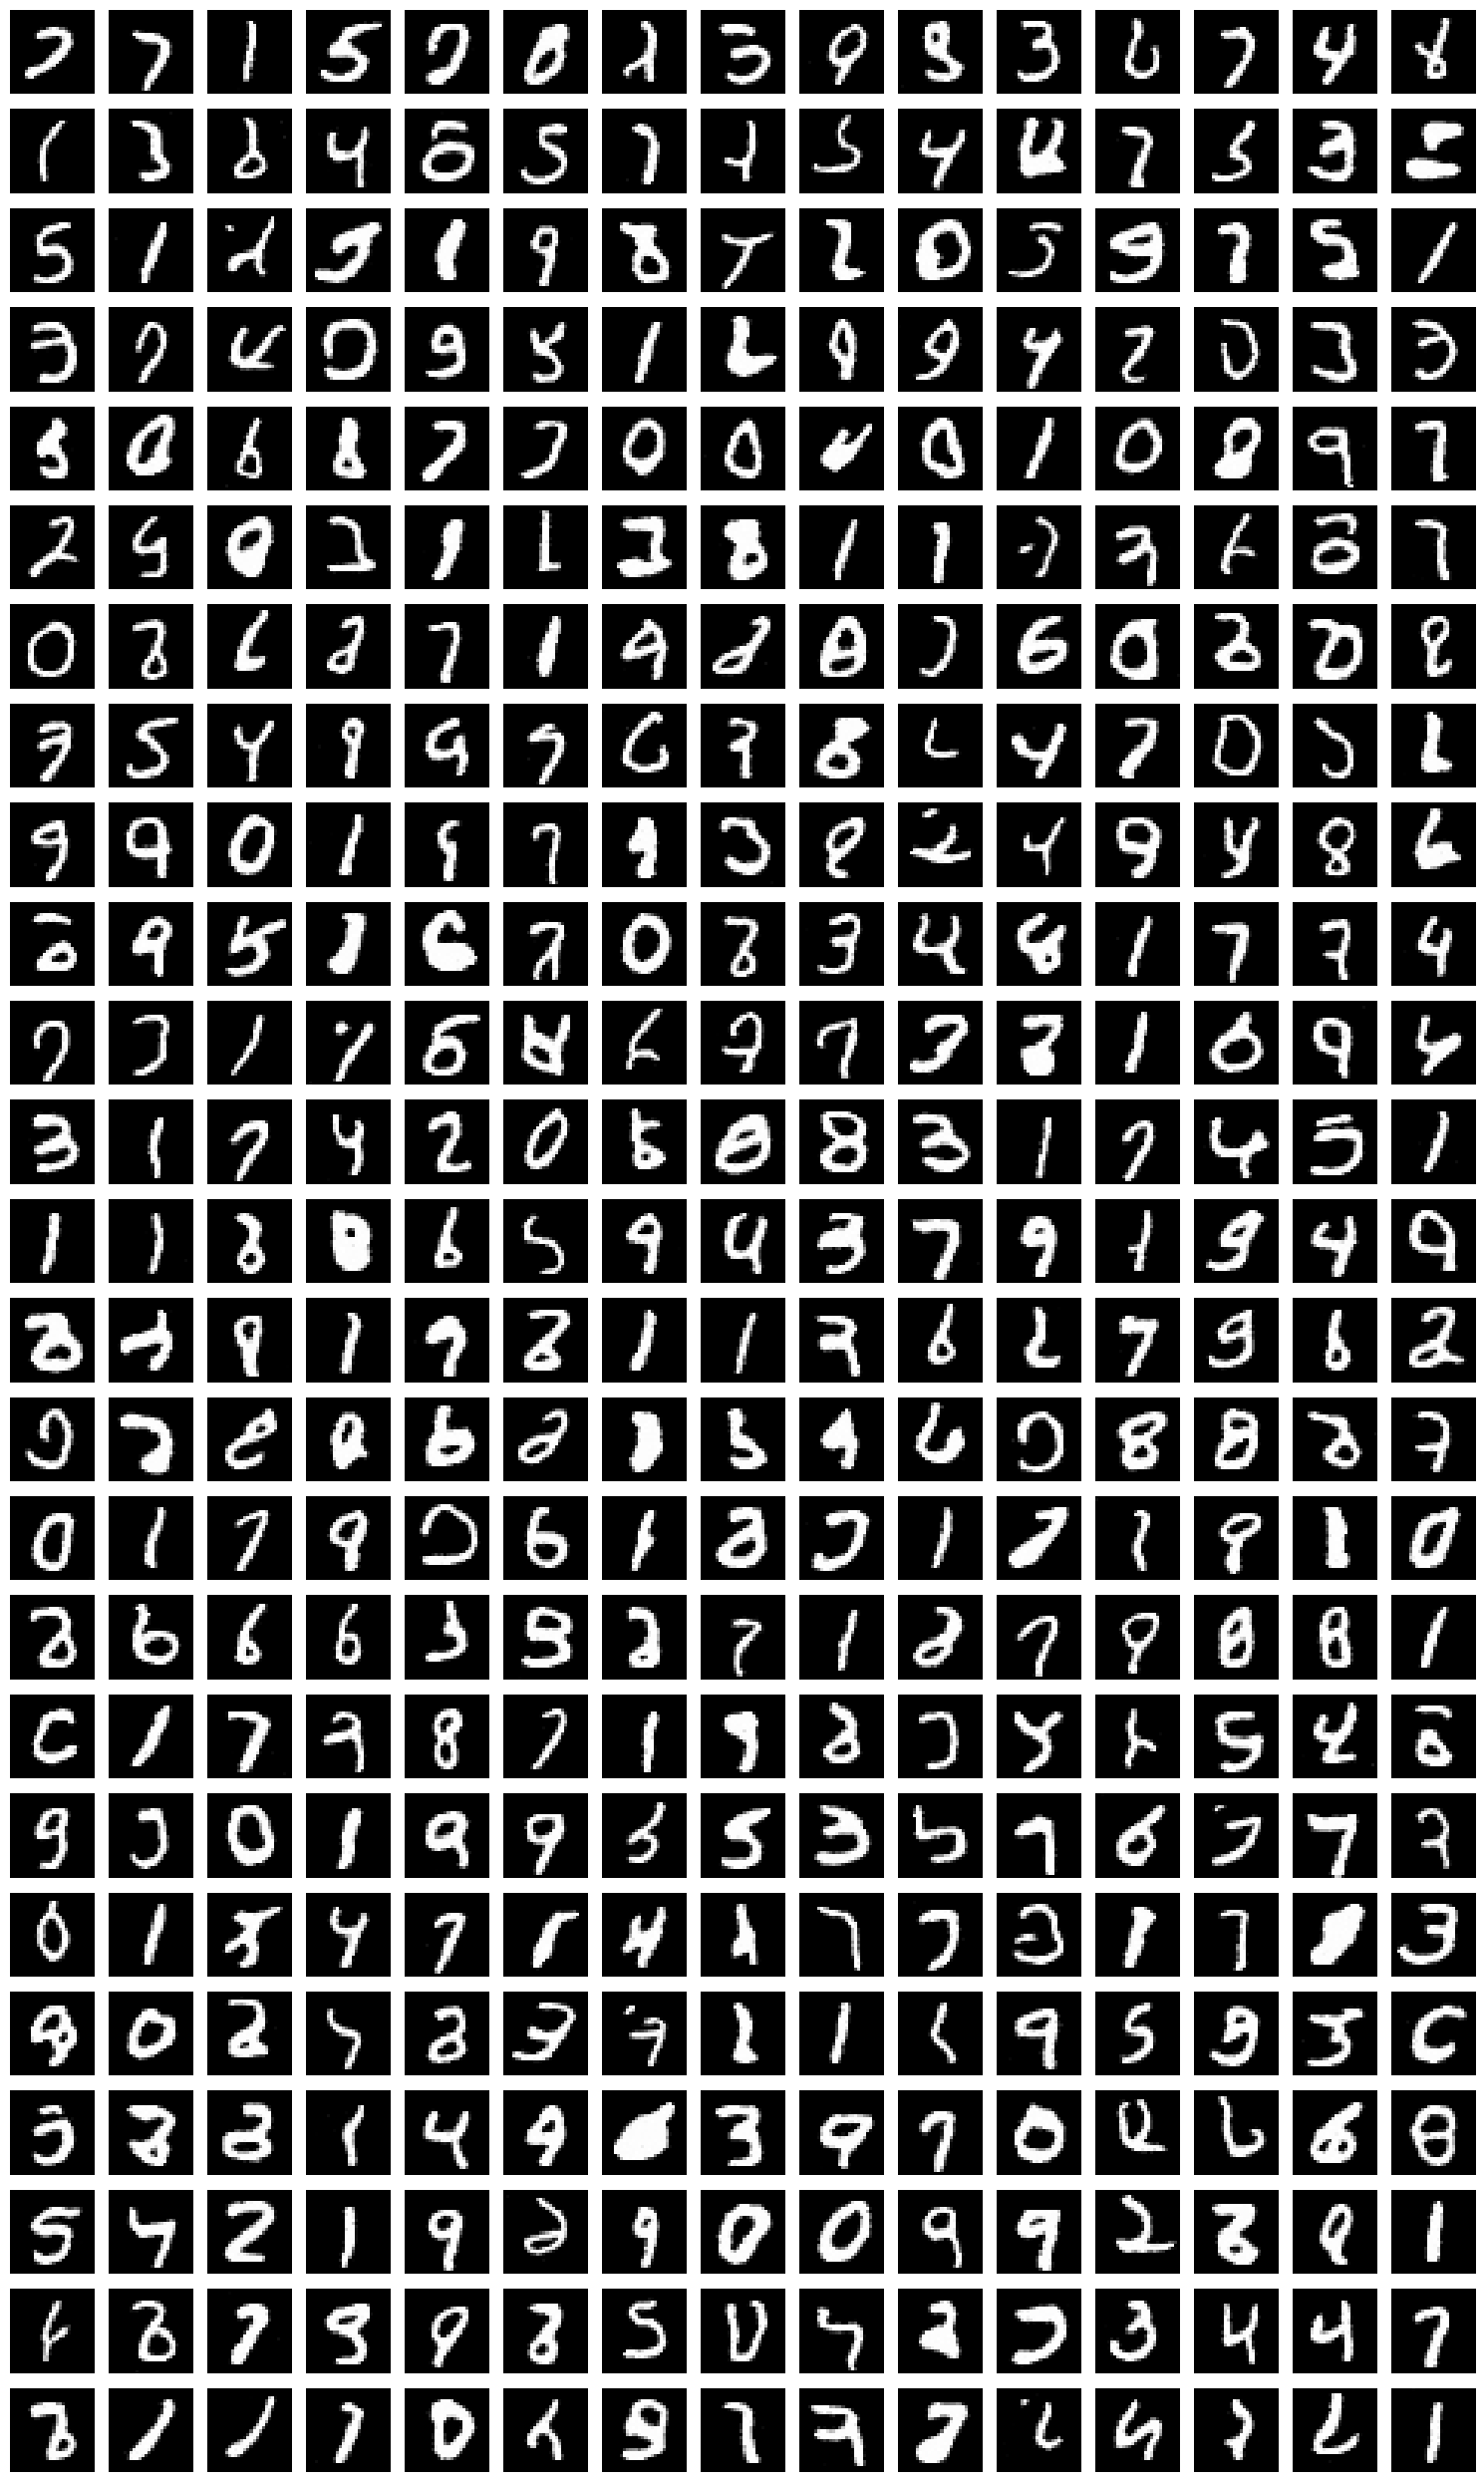

In [13]:

n_samples = 15*25
#s_name = 'Samples/mnist_unet_LBJF2000.npy'
s_name = 'Samples/MNIST/mnist_hollow_ExactSampling1000.npy'
samples = np.load(s_name)
samples = samples[550:]
samples = samples.reshape(-1, 1, 28, 28)
#saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
fig = plt.figure(figsize=(15, 25)) 
plt.subplots_adjust(wspace=0.001, hspace=0.001)
int(np.sqrt(n_samples))
for i in range(n_samples):
    plt.subplot(int(25), int(15), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")

plt.tight_layout()  
plt.savefig('mnist_hollow_ExactSampling1000.pdf', transparent=True)
plt.show()
plt.close()

In [ ]:


path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-25' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_599999_unet14Mlogits.pt'

path = 'SavedModels/MNISTHollow/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-03' # 2
config_name = 'config_001_hollow.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_539999_hollow.pt'

dataset_location = 'lib/datasets'

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

cfg = bookkeeping.load_config(config_path)
cfg.data.train = False
"""
if cfg.loss.name == 'CatRM':
    cfg.loss.name = 'SDDMNLL'
elif cfg.loss.name == 'CTElbo':
    cfg.loss.name = 'TauLDRNLL'
else:
    raise KeyError("Eval not defined!")

cfg.training.train_step_name = 'EvalMNIST'
"""
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)

optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}

state = bookkeeping.load_state(state, checkpoint_path)
cfg.training.n_iters = 600000 
cfg.sampler.sample_freq = 100000000
cfg.saving.checkpoint_freq = 10000
cfg.sampler.num_steps = 1000

# EvalMNIST

loss = losses_utils.get_loss(cfg)

training_step = training_utils.get_train_step(cfg)

sampler = sampling_utils.get_sampler(cfg)



print("Info:")
print("--------------------------------")
print("State Iter:", state["n_iter"])
print("--------------------------------")
print("Name Dataset:", cfg.data.name)
print("Loss Name:", cfg.loss.name)

print("--------------------------------")
print("Model Name:", cfg.model.name)
print("Number of Parameters: ", sum([p.numel() for p in model.parameters()]))

model.eval()

In [ ]:
steps = [1000]
sampler_names = ['CRMLBJF', 'CRMTauL', 'ExactSampling' ] # 'LBJF', 
#for sampler_n_i in sampler_name:
#    for step in steps:
#        data = np.load(f'unet_{sampler_n_i}{step}_mnist.npy')
for sampler_n in sampler_names:
    for step in steps:
        data = np.load(f'Samples/mnist_hollow_{sampler_n}{step}.npy')
        print(data.shape)
        dataset = dataset_utils.get_dataset(cfg, device, dataset_location)

        dataloader = torch.utils.data.DataLoader(dataset,
            batch_size=data.shape[0],
            shuffle=cfg.data.shuffle)
        for true_data in tqdm(dataloader):
            print(f'mnist_hollow_{sampler_n}{step}.npy')
            print("----------------------------------")
            print("Sampler:", sampler_n)
            print("Step:", step)
            fid = evaluate_fid_score(data, true_data.cpu().numpy(), 100)
            print("FID:", fid)
            break
# TauL: 10 20 30
# FID 284.3784917983221 119.89684926791293 41.04334648618652
# LBJF 104, TauL 77, Exact 17


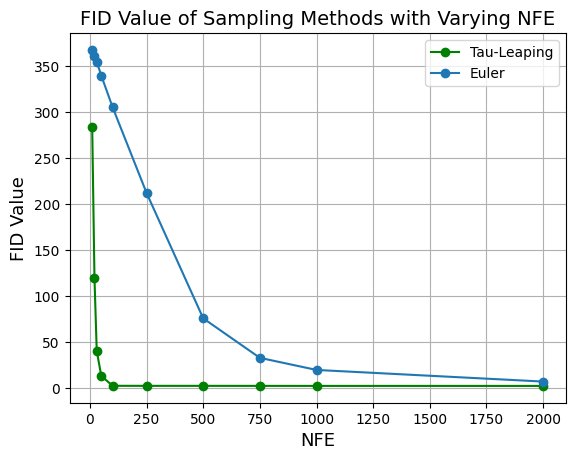

In [3]:
steps = np.array([10, 20, 30, 50, 100, 250, 500, 750, 1000, 2000])
fid_taul = np.array([283.87526811768316, 120.04226304249106, 40.6234648618652, 13.453524786963495, 2.6, 2.548404509903506, 2.5395556730263706, 2.51, 2.48, 2.460157370950734])
fid_lbjf = np.array([367.43394813969206, 360.795573791034, 354.6901690476625, 339.59518918406286, 305.2288604477556, 212.0276736955564, 75.84530505097865, 32.956622302615955, 19.817409823054646, 7.19])
plt.plot(steps, fid_taul, marker='o', color='green', label='Tau-Leaping')
plt.plot(steps, fid_lbjf, marker='o', label='Euler')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Sampling Methods with Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('fid.pdf')
plt.show()

In [ ]:
"""
n_rounds = 5000
nll = []

for i, minibatch in tqdm(enumerate(tqdm(dataloader))):
    minibatch = minibatch.to(device)
    l = training_step.step(state, minibatch.long(), loss)
    nll.append(l.item())

    if i >= n_rounds:
        print("Avg NLL:", np.mean(nll))
        break
# NLL: Hollow: 4.95, 4.96
# Unet: 5.15
"""   

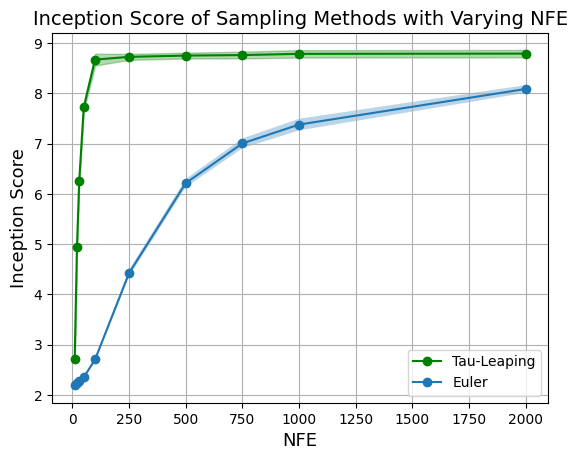

In [4]:

steps = np.array([10, 20, 30, 50, 100, 250, 500, 750, 1000, 2000])
mean_is_taul = np.array([2.708047858197907, 4.946, 6.260149524787618, 7.725075911310337, 8.670311295819452, 8.725352062102907, 8.750387442552915, 8.76098102664333, 8.785004667417176, 8.789941441541984])
std_is_taul = np.array([0.035763717879784655, 0.09223751449123928, 0.05542292679137494, 0.07471893518876059, 0.11749863261977536, 0.05961257597104094, 0.057613531976108634, 0.06736065870254852, 0.07408158674264428, 0.07343111567356189])

mean_is_lbjf = np.array([2.1935016592910244, 2.233561128867508, 2.2720786975418426, 2.3474579482515194, 2.703195286772994, 4.422914663421897, 6.212356745289218, 7.003172870037281, 7.3776977749287855, 8.086100926383237])
std_is_lbjf = np.array([0.016885548328526935, 0.01655479275116797, 0.01665546477191724, 0.021260056132834024, 0.042065063979126655, 0.0653358704449712, 0.08250910888402853, 0.09807975265868278, 0.11617335996188316, 0.07638698691732632])



plt.plot(steps, mean_is_taul, marker='o', color='green', label='Tau-Leaping')
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)],
                 [mean + std for mean, std in zip(mean_is_taul, std_is_taul)],
                 alpha=0.3, color='green')
plt.plot(steps, mean_is_lbjf, marker='o', label='Euler')
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_lbjf, std_is_lbjf)],
                 [mean + std for mean, std in zip(mean_is_lbjf, std_is_lbjf)],
                 alpha=0.3)

plt.xlabel('NFE', fontsize=13)
plt.ylabel('Inception Score', fontsize=13)
plt.title('Inception Score of Sampling Methods with Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('inception_score.pdf')
plt.show()
